GPU Server Specs

In [2]:
!nvidia-smi

Sat Nov 25 02:26:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
|  0%   46C    P8    24W / 350W |     10MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:41:00.0 Off |                  N/A |
|  0%   

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [4]:
file_paths = ['data/goemotions_1.csv', 'data/goemotions_2.csv', 'data/goemotions_3.csv']

df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
                  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
                  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
                  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
                  'relief', 'remorse', 'sadness', 'surprise', 'neutral']
df = df[['text'] + emotion_labels]

Dataset Size

In [5]:
print(f'Number of Reddit Samples: ',len(df))

Number of Reddit Samples:  211225


In [6]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['text'] = df.text.apply(process_text)

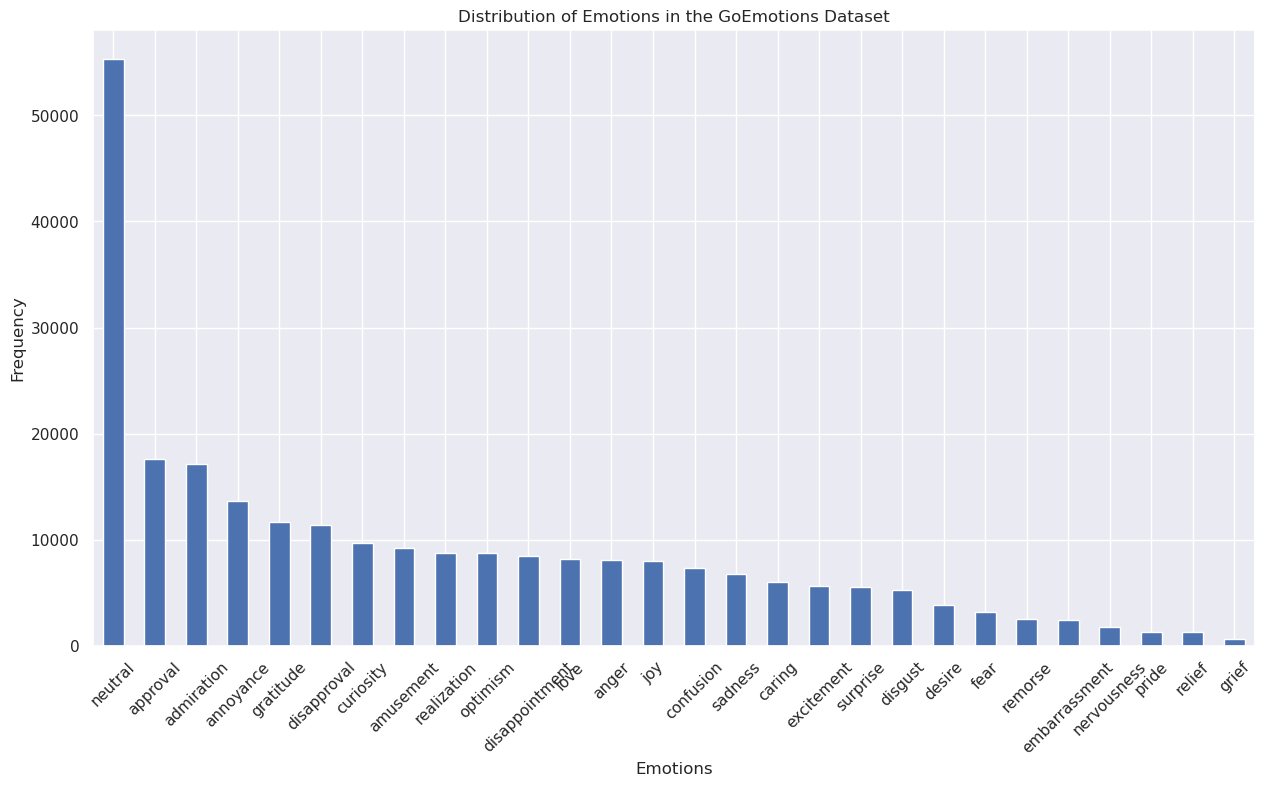

In [8]:
emotion_counts = df[emotion_labels].sum()
sorted_emotion_counts = emotion_counts.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sorted_emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions in the GoEmotions Dataset')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [9]:
df[emotion_labels].values

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Tokenization and Input Formatting

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
labels = df[emotion_labels].values
texts = df.text.values

input_ids = []
attention_masks = []

for text in texts:
    encoded_data = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split
from transformers import get_linear_schedule_with_warmup

In [12]:
# Create train-validation-test split
dataset = TensorDataset(input_ids, attention_masks, labels)
total_size = len(dataset)

train_size = int(0.8 * total_size)
test_val_size = total_size - train_size
val_size = int(0.5 * test_val_size)
test_size = test_val_size - val_size

train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])
val_dataset, test_dataset = random_split(test_val_dataset, [val_size, test_size])

batch_size = 32

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print('Training Size:', train_size)
print('Validation Size:', val_size)
print('Test Size:', test_size)

Training Size: 168980
Validation Size: 21122
Test Size: 21123


In [13]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotion_labels),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


device(type='cuda')

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix

In [17]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0

    # Use BCEWithLogitsLoss for multi-label classification
    loss_function = nn.BCEWithLogitsLoss()

    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        labels = batch[2]  # Keep labels separate from inputs

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits  # Extract logits from model outputs

            # Compute loss manually
            loss = loss_function(logits, labels.float())  # Convert labels to float
            loss_val_total += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = labels.cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [18]:
from tqdm.notebook import tqdm
# Loss function for multi-label classification
loss_function = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        # Ensure batch data is on the same device as the model
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = loss_function(logits, labels.float())  # Convert labels to float to match logits
        loss_train_total += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    tqdm.write(f'\nEpoch {epoch}')
    train_loss = loss_train_total/len(train_dataloader)   
    train_losses.append(train_loss)         
    tqdm.write(f'Training loss: {train_loss}')

    val_loss, predictions, true_labels = evaluate(validation_dataloader)
    val_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1305350470816044
Validation loss: 0.11453170939130249


Epoch 2:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.10987930590965106
Validation loss: 0.11166516477284381


Epoch 3:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.10416764837930068
Validation loss: 0.11239536971124325


Epoch 4:   0%|          | 0/5281 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09993614689647147
Validation loss: 0.11273230646093026


Check how well model is fitting

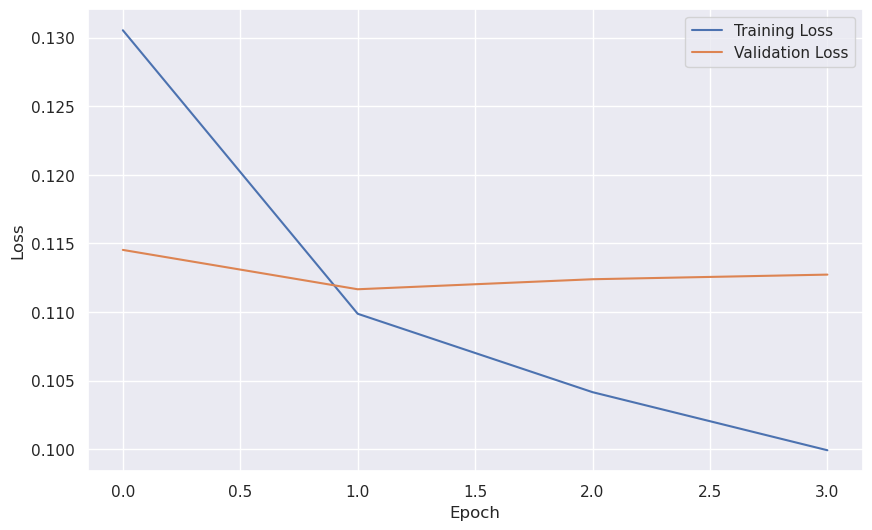

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
output_dir = './goemotions'  # Directory where the model and tokenizer will be saved

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./goemotions/tokenizer_config.json',
 './goemotions/special_tokens_map.json',
 './goemotions/vocab.txt',
 './goemotions/added_tokens.json')

In [42]:
# Reload model and tokenizer for inference
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)
model.to(device)

# Function to predict sentiment
def predict_emotions(text):
    encoded_dict = tokenizer.encode_plus(
                        text, 
                        add_special_tokens=True,
                        max_length=128,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )
    input_id = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    predicted_prob = torch.sigmoid(logits).cpu().numpy()
    return predicted_prob

# Test with a sample text
sample_text = "I'm really happy to learn new things!"
predicted_prob = predict_emotions(sample_text)
predicted_emotions_bin = (predicted_prob > 0.3).astype(int)
predicted_emotions = [emotion_labels[i] for i, pred in enumerate(predicted_emotions_bin[0]) if pred == 1]
print("Predicted Emotion Probabilities:", predicted_prob)
print("Predicted Emotions:", predicted_emotions)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Predicted Emotion Probabilities: [[4.5965526e-02 1.4553573e-02 2.1696070e-03 4.1323290e-03 5.4950062e-02
  1.9039309e-02 1.6035694e-03 4.0181228e-03 8.4526297e-03 2.5884937e-03
  2.6960056e-03 8.2990353e-04 7.7148620e-04 1.4752650e-01 5.7428214e-04
  3.3926144e-02 7.5786543e-04 7.7385521e-01 1.8215923e-02 1.0029830e-03
  2.2097776e-02 5.7736565e-03 8.3298795e-03 1.3725624e-02 1.2107533e-03
  2.7229979e-03 4.6602674e-03 2.3692885e-02]]
Predicted Emotions: ['joy']


In [22]:
# Evaluate on Test Set
test_loss, predictions, true_labels = evaluate(test_dataloader)

In [24]:
from sklearn.metrics import (hamming_loss, accuracy_score, jaccard_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, 
                             classification_report)

# Assuming 'predictions' and 'true_labels' are your model outputs and true labels respectively
# Convert logits to probabilities
probabilities = torch.sigmoid(torch.tensor(predictions)).numpy()

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (probabilities > threshold).astype(int)
print("\nClassification Report:\n")
print(classification_report(true_labels, binary_predictions, target_names=emotion_labels))



Classification Report:

                precision    recall  f1-score   support

    admiration       0.59      0.52      0.55      1720
     amusement       0.60      0.66      0.63       931
         anger       0.48      0.20      0.28       832
     annoyance       0.33      0.02      0.04      1312
      approval       0.46      0.11      0.17      1720
        caring       0.42      0.20      0.27       582
     confusion       0.57      0.16      0.26       765
     curiosity       0.48      0.19      0.28       996
        desire       0.53      0.22      0.31       387
disappointment       0.51      0.05      0.10       860
   disapproval       0.41      0.13      0.19      1135
       disgust       0.52      0.13      0.21       532
 embarrassment       0.53      0.07      0.13       257
    excitement       0.53      0.12      0.20       544
          fear       0.57      0.35      0.44       337
     gratitude       0.87      0.78      0.82      1117
         grief       0

/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:

# Hamming Loss
hammingLoss = hamming_loss(true_labels, binary_predictions)
print("Hamming Loss:", hammingLoss)

# Exact Match Ratio (Subset Accuracy)
exactMatchRatio = accuracy_score(true_labels, binary_predictions)
print("Exact Match Ratio:", exactMatchRatio)

# Jaccard Similarity
jaccardSimilarity = jaccard_score(true_labels, binary_predictions, average='samples')
print("Jaccard Similarity:", jaccardSimilarity)

# Micro Averaged Precision, Recall, F1-Score
precision_micro = precision_score(true_labels, binary_predictions, average='micro')
recall_micro = recall_score(true_labels, binary_predictions, average='micro')
f1_micro = f1_score(true_labels, binary_predictions, average='micro')
print("Micro-Averaged Precision:", precision_micro)
print("Micro-Averaged Recall:", recall_micro)
print("Micro-Averaged F1-Score:", f1_micro)

# Macro Averaged Precision, Recall, F1-Score
precision_macro = precision_score(true_labels, binary_predictions, average='macro')
recall_macro = recall_score(true_labels, binary_predictions, average='macro')
f1_macro = f1_score(true_labels, binary_predictions, average='macro')
print("Macro-Averaged Precision:", precision_macro)
print("Macro-Averaged Recall:", recall_macro)
print("Macro-Averaged F1-Score:", f1_macro)


Hamming Loss: 0.03877628313077823
Exact Match Ratio: 0.2547933532168726
Jaccard Similarity: 0.2817849196204543
Micro-Averaged Precision: 0.5847100472016183
Micro-Averaged Recall: 0.27810295060936496
Micro-Averaged F1-Score: 0.37692892849380566
Macro-Averaged Precision: 0.49811187354704684
Macro-Averaged Recall: 0.22485267959054214
Macro-Averaged F1-Score: 0.28025022937005506


/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/19aag9/ENTER/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
# ROC-AUC and PR-AUC for each label
for i, label in enumerate(emotion_labels):
    roc_auc = roc_auc_score(true_labels[:, i], probabilities[:, i])
    pr_auc = average_precision_score(true_labels[:, i], probabilities[:, i])
    print(f"ROC-AUC for {label}: {roc_auc:.4f}, PR-AUC for {label}: {pr_auc:.4f}")



ROC-AUC for admiration: 0.9127, PR-AUC for admiration: 0.5620
ROC-AUC for amusement: 0.9437, PR-AUC for amusement: 0.5820
ROC-AUC for anger: 0.8827, PR-AUC for anger: 0.3192
ROC-AUC for annoyance: 0.8062, PR-AUC for annoyance: 0.2050
ROC-AUC for approval: 0.7639, PR-AUC for approval: 0.2708
ROC-AUC for caring: 0.8876, PR-AUC for caring: 0.2780
ROC-AUC for confusion: 0.8936, PR-AUC for confusion: 0.3347
ROC-AUC for curiosity: 0.9235, PR-AUC for curiosity: 0.4006
ROC-AUC for desire: 0.8807, PR-AUC for desire: 0.2831
ROC-AUC for disappointment: 0.8257, PR-AUC for disappointment: 0.2097
ROC-AUC for disapproval: 0.8416, PR-AUC for disapproval: 0.2598
ROC-AUC for disgust: 0.8815, PR-AUC for disgust: 0.2718
ROC-AUC for embarrassment: 0.8473, PR-AUC for embarrassment: 0.1944
ROC-AUC for excitement: 0.8633, PR-AUC for excitement: 0.2516
ROC-AUC for fear: 0.9289, PR-AUC for fear: 0.4542
ROC-AUC for gratitude: 0.9720, PR-AUC for gratitude: 0.8525
ROC-AUC for grief: 0.9324, PR-AUC for grief: 0.063

In [29]:
# Average Precision
averagePrecision = average_precision_score(true_labels, probabilities, average='macro')
print("Average Precision:", averagePrecision)

Average Precision: 0.3367354081014352
